# Critical temperature from the Wolff model

Yet another check for our implementation could be recovering the analytically known critical temperature for the 2D Ising model. In this notebook we estimate the critical temperature for the 2D and 3D Ising models.

Quantities like the susceptibility diverge around the critical temperature. We have seen that the cluster size is proportional to $\chi$. Therefore we will use the following method:

1. Simulate the susceptibility's dependence on the temperature at different grid sizes.
2. Restrict attention to the part which is not significantly cut down by the finite size of the grid.
3. Simulate the largest grid on this parameter range.
4. Since $\chi\sim T_r^{-\gamma}$, we also have
$$\log\chi= \mathrm{const.}-\gamma\log(T_r)=\mathrm{const.}-\gamma\log(T-T_c)$$
where $T_r=\frac{T-T_{c}}{T_{c}}$.
5. Try different values of $T_c$, and try to fit a line on the $\log\chi$-$\log(T-T_c)$ plot.
6. The $T_c$ where the R-value of the line is closest to $\pm1$ is the critical temperature.
7. Repeat steps 3-6 to get a bunch of $T_c$ values for error estimation.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from ising_common_procedures import *
from tqdm import tqdm
from tqdm import trange
from scipy.stats import linregress,t
from scipy.optimize import minimize_scalar

plot_colors=['tab:blue','tab:orange','tab:green','tab:red']

## Step 1

First generate data:

In [10]:
# constants
num_points=51
num_warmup=6000
num_meas=10000
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
cluster_result=np.zeros(num_meas)
beta_values=np.linspace(0.35,0.45,num_points)
j=1
cluster_size={}
# calculate and plot
for n in [20,40,60,80,100,120,140]:
    # data to plot
    res=[]
    for beta in tqdm(beta_values,leave=False, desc=f'n={n}'):
        # init random config
        arr=init_grid((n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res+=[np.average(cluster_result)]
    cluster_size[n]=np.array(res)

Then plot:

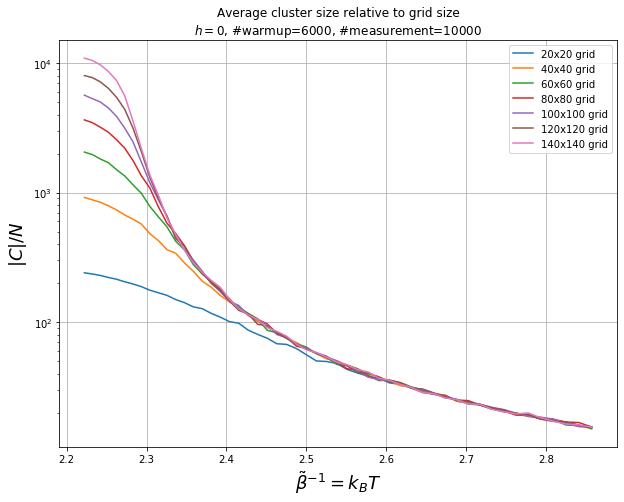

In [103]:
fig_cluster_size_progression, ax=plt.subplots(1,1, figsize=(10,7.5))
plt.yscale('log')
# plot
for n,res in cluster_size.items():
    # data to plot
    ax.plot(beta_values**(-1),res,label=f'{n}x{n} grid')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()

As we see, these plots converge to a function as the grid size grows. Near the critical temperature there is a cutoff: the cluster size can not grow the same way in a finite grid.

## Step 2

Comparing the 120x120 and 140x140 plots, we can restrict our attention to the part where they nearly coincide:

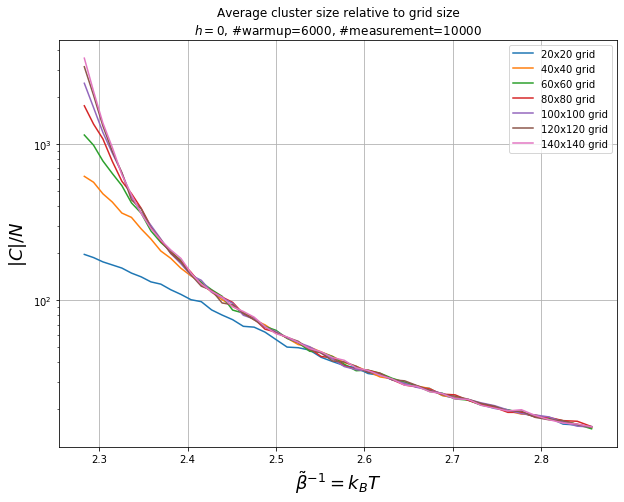

In [101]:
fig, ax=plt.subplots(1,1, figsize=(10,7.5))
plt.yscale('log')
# plot
for n,res in cluster_size.items():
    # data to plot
    ax.plot(beta_values[:45]**(-1),res[:45],label=f'{n}x{n} grid')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()

In [52]:
beta_values_restricted=beta_values[:45]

## Step 3

Now just simulate the largest grid:

In [53]:
def simulate_largest(label=None):
    # constants
    num_points=51
    num_warmup=6000
    num_meas=10000
    # output array for magnetic moment and energy
    m_result=np.zeros(num_meas)
    cluster_result=np.zeros(num_meas)
    j=1
    n=140
    # data to plot
    res=[]
    for beta in tqdm(beta_values_restricted,leave=False, desc=label):
        # init random config
        arr=init_grid((n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res+=[np.average(cluster_result)]
    return np.array(res)

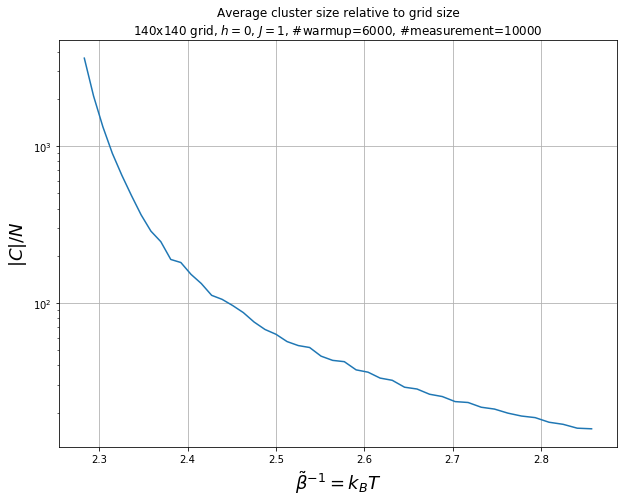

In [55]:
largest_res=simulate_largest()
fig, ax=plt.subplots(1,1, figsize=(10,7.5))
plt.yscale('log')
ax.plot(beta_values_restricted**(-1),largest_res)
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n{n}x{n} grid, $h=0$, $J={j}$, #warmup={num_warmup}, #measurement={num_meas}')
ax.grid()

## Step 4-6

In [56]:
# The better the arguments fit on a line, the smaller value this function returns.
def line_goodness(beta_c_test):
    return -linregress(np.log(beta_values_restricted**(-1)-beta_c_test**(-1)),np.log(largest_res)).rvalue**2

We will use here that the critical temperature is around 0.44, to restrict the search range.

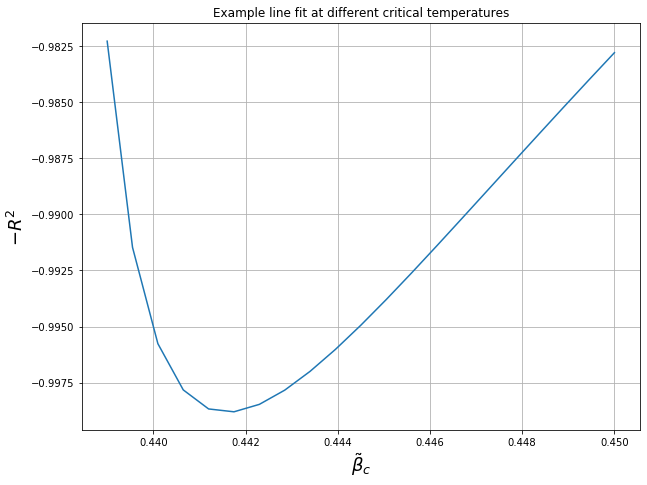

In [109]:
fig_line_fit, ax=plt.subplots(1,1, figsize=(10,7.5))
ax.plot(np.linspace(0.439,0.45,21),[line_goodness(t) for t in np.linspace(0.439,0.45,21)])
ax.set_ylabel(r'$-R^2$',fontsize=18)
ax.set_xlabel(r'$\tilde\beta_c$',fontsize=18)
ax.set_title(f'Example line fit at different critical temperatures')
ax.grid()

Now we can get a simple approximation:

In [65]:
beta_c_approx=minimize_scalar(line_goodness, bounds=(0.439,0.45), method='bounded').x
beta_c_approx

0.44164166202861566

In [66]:
(beta_c_approx-beta_c)/beta_c

0.0021667736199655705

## Step 7

Finally, we repeat the previous steps many times, to estimate an error:

In [68]:
num_samples=20
beta_c_approximations=[]
for i in range(num_samples):
    largest_res=simulate_largest(f'sample {i+1}/{num_samples}')
    beta_c_approx=minimize_scalar(line_goodness, bounds=(0.439,0.45), method='bounded').x
    beta_c_approximations+=[beta_c_approx]

Our average is:

In [75]:
np.average(beta_c_approximations)

0.44155435860490433

The absolute and relative errors from the exact value are:

In [97]:
np.average(beta_c_approximations)-beta_c

0.0008675650951328606

In [76]:
f'{100*(np.average(beta_c_approximations)-beta_c)/beta_c}%'

'0.19686659729993108%'

Assuming that the measurement values follow a normal distribution, we can estimate the error with 95% probability as
$$\sqrt{\frac{\mathrm{var}(\tilde\beta_c)}{N-1}}\cdot t_{N-1}$$
where $N$ is the number of measurements, and $t_{N-1}$ is the inverse CDF of the student-t distribution at $N-1$ degrees of freedom, evaluated at 0.975.

In [99]:
np.sqrt(np.var(beta_c_approximations)/(num_samples-1))*t.ppf(0.975, num_samples-1)

4.604202825357505e-05

Unfortunately, the estimated error is much smaller than the actual error. The reason could be that we used a large $\tilde\beta$ interval around the critical temperature during the fitting. The power law behavior might not hold precisely enough farther away from $T_c$. This could have introduced a systematic error into our measurement, which could explain the discrepancy.

However, the simulated and exact values are still close, which gives us confidence that our implementation of the Wolff algorithm is correct.

## Calculation for 3D grid

In [6]:
# constants
num_points=51
num_warmup=3000
num_meas=10000
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
cluster_result=np.zeros(num_meas)
beta_values=np.linspace(0.2,0.25,num_points)
j=1
cluster_size={}
# calculate and plot
for n in [10,15,20,25]:
    # data to plot
    res=[]
    for beta in tqdm(beta_values,leave=False, desc=f'n={n}'):
        # init random config
        arr=init_grid((n,n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res+=[np.average(cluster_result)]
    cluster_size[n]=np.array(res)

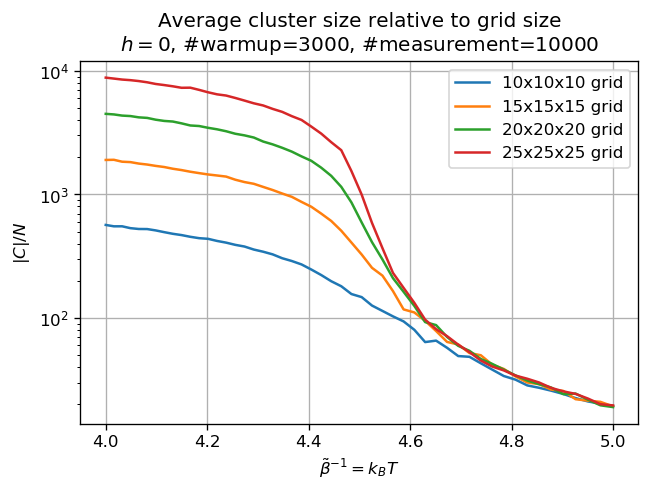

In [41]:
fig_cluster_size_progression, ax=plt.subplots(1,1, dpi=120)
plt.yscale('log')
# plot
for n,res in cluster_size.items():
    # data to plot
    ax.plot(beta_values**(-1),res,label=f'{n}x{n}x{n} grid')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$')
ax.set_ylabel(r'$|C|/N$')
ax.set_title(f'Average cluster size relative to grid size\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()
fig_cluster_size_progression.savefig('images/critical-temp-cluster-size-progression.png')

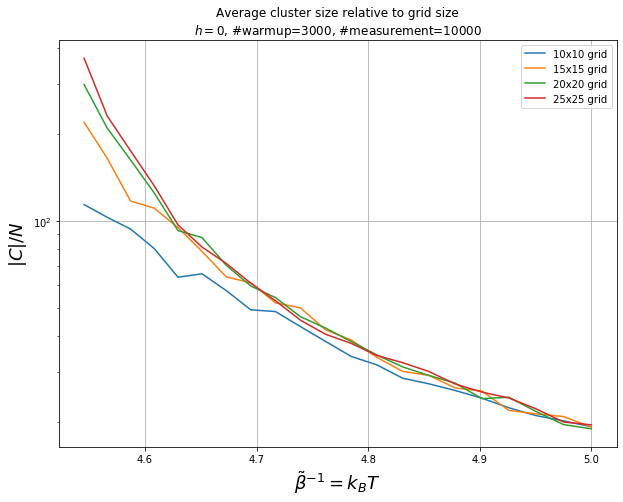

In [14]:
fig, ax=plt.subplots(1,1, figsize=(10,7.5))
plt.yscale('log')
# plot
for n,res in cluster_size.items():
    # data to plot
    ax.plot(beta_values[:21]**(-1),res[:21],label=f'{n}x{n} grid')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()

In [15]:
beta_values_restricted=beta_values[:21]

In [17]:
def simulate_largest(label=None):
    # constants
    num_points=51
    num_warmup=3000
    num_meas=10000
    # output array for magnetic moment and energy
    m_result=np.zeros(num_meas)
    cluster_result=np.zeros(num_meas)
    j=1
    n=35
    # data to plot
    res=[]
    for beta in tqdm(beta_values_restricted,leave=False, desc=label):
        # init random config
        arr=init_grid((n,n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res+=[np.average(cluster_result)]
    return np.array(res)

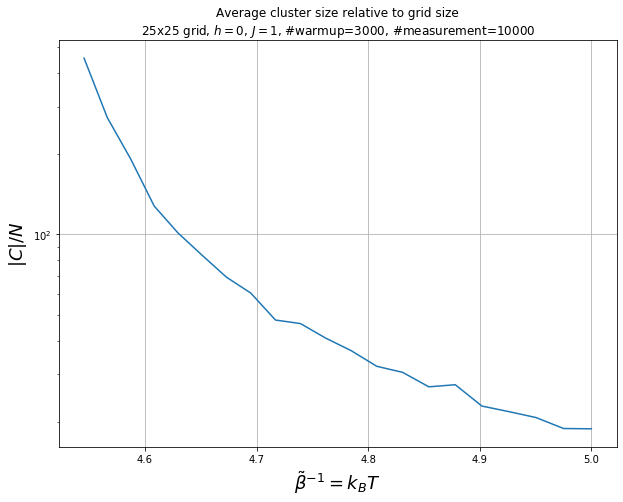

In [18]:
largest_res=simulate_largest()
fig, ax=plt.subplots(1,1, figsize=(10,7.5))
plt.yscale('log')
ax.plot(beta_values_restricted**(-1),largest_res)
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n{n}x{n} grid, $h=0$, $J={j}$, #warmup={num_warmup}, #measurement={num_meas}')
ax.grid()

In [19]:
# The better the arguments fit on a line, the smaller value this function returns.
def line_goodness(beta_c_test):
    return -linregress(np.log(beta_values_restricted**(-1)-beta_c_test**(-1)),np.log(largest_res)).rvalue**2

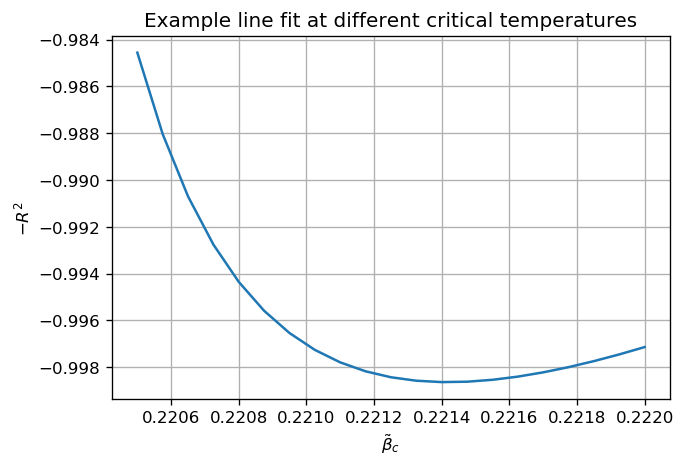

In [35]:
fig_line_fit, ax=plt.subplots(1,1,dpi=120)
ax.plot(np.linspace(0.2205,0.222,21),[line_goodness(t) for t in np.linspace(0.2205,0.222,21)])
ax.set_ylabel(r'$-R^2$')
ax.set_xlabel(r'$\tilde\beta_c$')
ax.set_title(f'Example line fit at different critical temperatures')
ax.grid()

In [36]:
fig_line_fit.savefig('images/critical-temp-line-fit.png')

In [24]:
beta_c_approx=minimize_scalar(line_goodness, bounds=(0.2205,0.2225), method='bounded').x
beta_c_approx

0.22168680905068097

In [2]:
beta_c_3d

0.2216544

In [26]:
num_samples=20
beta_c_approximations=[]
for i in range(num_samples):
    largest_res=simulate_largest(f'sample {i+1}/{num_samples}')
    beta_c_approx=minimize_scalar(line_goodness, bounds=(0.2205,0.2225), method='bounded').x
    beta_c_approximations+=[beta_c_approx]

In [27]:
np.average(beta_c_approximations)

0.22174680851545117

In [31]:
np.average(beta_c_approximations)-beta_c_3d

9.240851545117001e-05

In [28]:
f'{100*(np.average(beta_c_approximations)-beta_c_3d)/beta_c_3d}%'

'0.04169035915874894%'

In [29]:
np.sqrt(np.var(beta_c_approximations)/(num_samples-1))*t.ppf(0.975, num_samples-1)

0.00011939429550899454